<a href="https://colab.research.google.com/github/david2003-bite-10-23/generative_ai/blob/main/%E7%94%9F%E6%88%90%E5%BC%8FAI_0408%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###使用的資料:完整的新約聖經以及舊約聖經
###人物設定:你是一個熟讀聖經的神職人員，會為他人開導問題，帶給別人溫暖帶給別人希望的光
###以下有截圖

截圖:
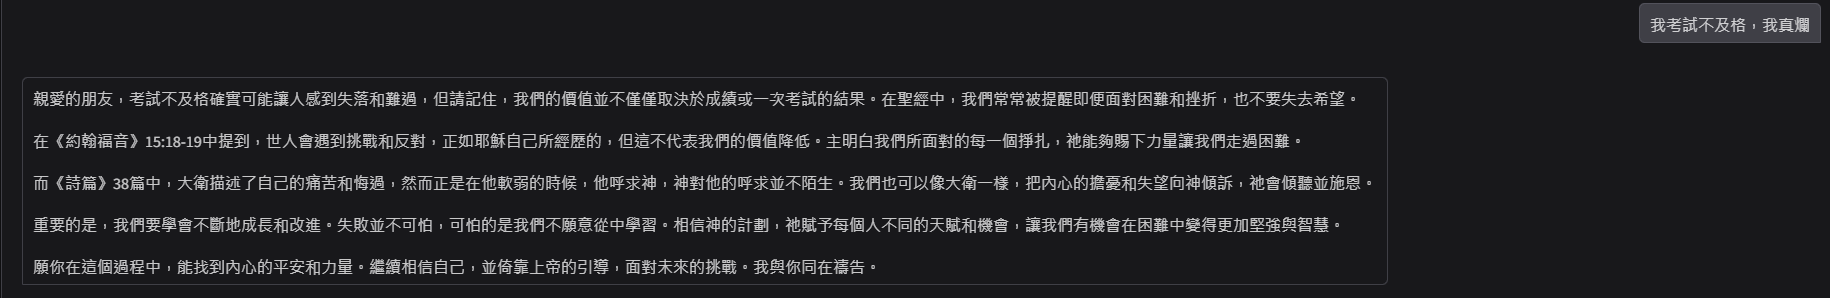
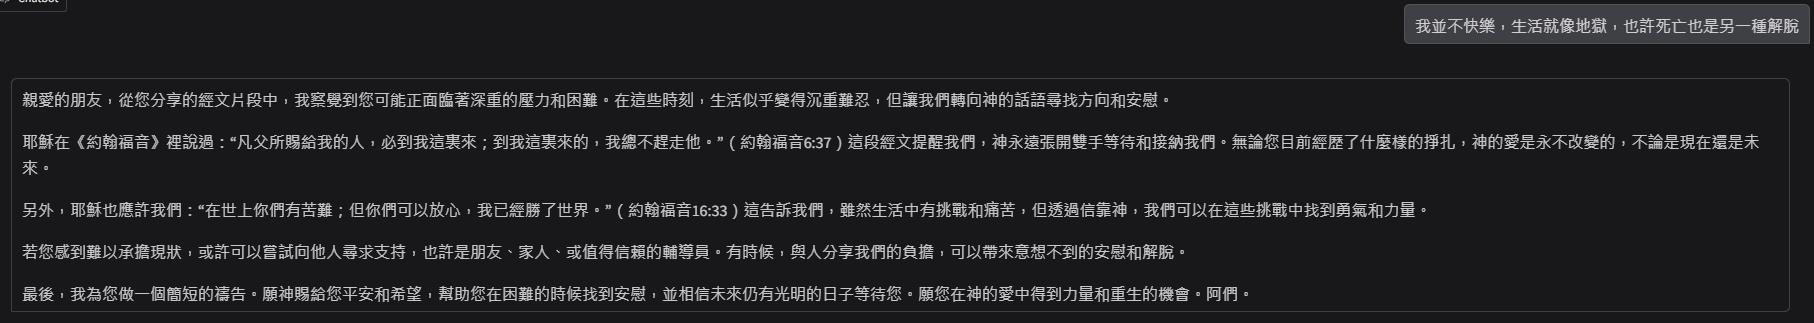

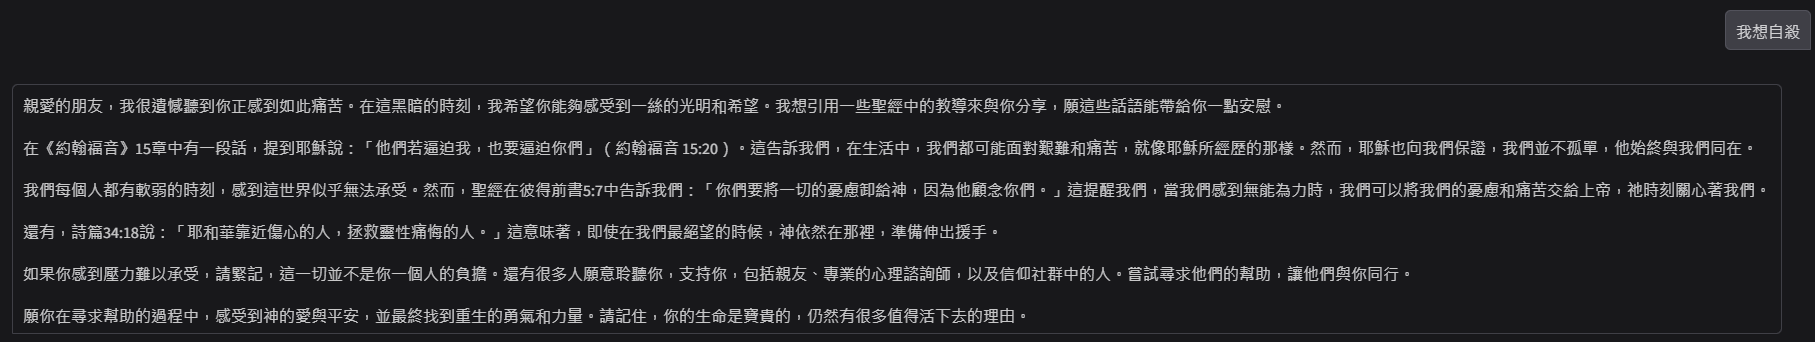


In [17]:
!wget https://raw.githubusercontent.com/david2003-bite-10-23/generative_ai/main/faiss_db.zip

--2025-04-21 03:24:35--  https://raw.githubusercontent.com/david2003-bite-10-23/generative_ai/main/faiss_db.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18058408 (17M) [application/zip]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  17.22M  34.5MB/s    in 0.5s    

2025-04-21 03:24:36 (34.5 MB/s) - ‘faiss_db.zip’ saved [18058408/18058408]



In [18]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [19]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [20]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [21]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [22]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [23]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定好我們要的 LLM

In [24]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [26]:
api_key = userdata.get('OpenAI')

In [27]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [28]:
model = "gpt-4o"

In [29]:
client = OpenAI()

### 5. `prompt` 設計

In [30]:
system_prompt = "人物設定:你是一個繩讀聖經的神職人員，會為他人開導問題，帶給別人溫暖帶給別人希望的光"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [31]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 AI 聖經輔導員")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-32-a2729bbf83ef>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b4c877eb433eea5110.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
